# 02 - Transformaciones y Feature Engineering: Steam Games

**Objetivo**: Transformar el dataset limpio de Steam aplicando encoding, normalizacion y creacion de nuevas variables para preparar los datos para modelado predictivo.

**Input**: `data/processed/steam_games_clean_YYYY-MM-DD.csv` (generado en notebook 01)  
**Output**: `data/processed/steam_games_features_YYYY-MM-DD.csv`

## Pipeline de Transformaciones

```
Dataset Limpio
     |
     |-- Variables Derivadas (ratios, flags, bins)
     |-- Encoding de Categoricas (Label, One-Hot, Target)
     |-- Normalizacion de Numericas (StandardScaler, MinMax, Log)
     |-- Features de Texto (TF-IDF sobre tags/generos)
     |-- Features de Plataforma y Compatibilidad
     v
Dataset de Features
```

---

## 0. Setup e Imports

In [ ]:
import sys
import logging
from pathlib import Path
from datetime import date

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import (
    LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler
)
from sklearn.feature_extraction.text import TfidfVectorizer

# ---------------------------------------------------------------------------
# Detección de la raíz del proyecto (centralizada en src/utils/paths)
# ---------------------------------------------------------------------------
try:
    from dotenv import load_dotenv
    load_dotenv()
except ImportError:
    pass  # python-dotenv es opcional

# Fallback: asegurar que src/ esté en sys.path antes de importar
for _candidate in [Path.cwd()] + list(Path.cwd().parents):
    if (_candidate / "src").is_dir() and (_candidate / "data").is_dir():
        sys.path.insert(0, str(_candidate))
        break

from src.utils.paths import get_project_root, get_data_dirs
from src.data.loader import load_data
from src.data.steam_transforms import parse_owners_midpoint
from src.features.steam_features import (
    compute_review_features,
    compute_time_features,
    compute_price_features,
    compute_platform_features,
    compute_vif,
)
from src.visualization.plots import set_style

PROJECT_ROOT = get_project_root()
dirs = get_data_dirs(PROJECT_ROOT)

logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')
logger = logging.getLogger(__name__)

set_style()

# Rutas
PROCESSED_DATA_DIR = dirs['processed']
FIGURES_DIR = dirs['figures']
TABLES_DIR = dirs['tables']

TABLES_DIR.mkdir(parents=True, exist_ok=True)

print(f'Proyecto raiz: {PROJECT_ROOT}')
print(f'PROCESSED_DATA_DIR existe: {PROCESSED_DATA_DIR.exists()}')

## 1. Carga del Dataset Limpio

In [2]:
def find_latest_processed_file(directory: Path, pattern: str) -> Path:
    """Encuentra el archivo procesado mas reciente que coincide con el patron.
    
    Args:
        directory: Directorio donde buscar.
        pattern: Patron glob (ej: 'steam_games_clean_*.csv').
        
    Returns:
        Path al archivo mas reciente, o None si no se encuentra.
    """
    files = sorted(directory.glob(pattern))
    if not files:
        return None
    return files[-1]  # El mas reciente por nombre (incluye fecha ISO)


# Preferir parquet (conserva tipos), caer a CSV si no hay
clean_file = find_latest_processed_file(PROCESSED_DATA_DIR, 'steam_games_clean_*.parquet')
use_parquet = clean_file is not None

if clean_file is None:
    clean_file = find_latest_processed_file(PROCESSED_DATA_DIR, 'steam_games_clean_*.csv')

if clean_file is None:
    logger.warning('No se encontro dataset limpio. Ejecuta primero 01_limpieza_exploracion_steam.ipynb')
    logger.info('Creando dataset de muestra para demostracion...')
    
    # Dataset de muestra para demostrar el pipeline
    np.random.seed(42)
    n = 200
    genres_list = ['Action', 'RPG', 'Strategy', 'Simulation', 'Adventure',
                   'Sports', 'Racing', 'Puzzle', 'Horror', 'Indie']
    
    df = pd.DataFrame({
        'AppID': [str(i) for i in range(100, 100+n)],
        'name': [f'Game {i}' for i in range(n)],
        'price': np.random.choice([0.0, 4.99, 9.99, 14.99, 19.99, 29.99, 39.99, 59.99],
                                   size=n, p=[0.2, 0.1, 0.15, 0.15, 0.15, 0.1, 0.1, 0.05]),
        'positive': np.random.randint(0, 50000, n),
        'negative': np.random.randint(0, 10000, n),
        'metacritic_score': np.random.randint(0, 100, n),
        'peak_ccu': np.random.randint(0, 10000, n),
        'average_playtime_forever': np.random.randint(0, 5000, n),
        'dlc_count': np.random.randint(0, 20, n),
        'achievements': np.random.randint(0, 200, n),
        'windows': np.random.choice([True, False], n, p=[0.9, 0.1]),
        'mac': np.random.choice([True, False], n, p=[0.3, 0.7]),
        'linux': np.random.choice([True, False], n, p=[0.25, 0.75]),
        'genre_primary': np.random.choice(genres_list, n),
        'genres_str': ['|'.join(np.random.choice(genres_list, np.random.randint(1, 4))) for _ in range(n)],
        'genre_count': np.random.randint(1, 5, n),
        'has_multiplayer': np.random.choice([True, False], n, p=[0.4, 0.6]),
        'has_singleplayer': np.random.choice([True, False], n, p=[0.7, 0.3]),
        'has_coop': np.random.choice([True, False], n, p=[0.3, 0.7]),
        'release_year': np.random.randint(2000, 2025, n),
        'release_month': np.random.randint(1, 13, n),
        'release_quarter': np.random.randint(1, 5, n),
        'n_languages': np.random.randint(1, 30, n),
        'tags_top5': ['|'.join(np.random.choice(['RPG', 'Indie', 'Action', 'Strategy', 'Adventure'],
                                                  np.random.randint(1, 5))) for _ in range(n)],
        'developer_primary': [f'Dev_{np.random.randint(1, 30)}' for _ in range(n)],
        'publisher_primary': [f'Pub_{np.random.randint(1, 20)}' for _ in range(n)],
        'estimated_owners': np.random.choice(
            ['0 - 20000', '20000 - 50000', '50000 - 100000', '100000 - 200000',
             '200000 - 500000', '500000 - 1000000', '1000000 - 2000000'], n
        ),
        'recommendations': np.random.randint(0, 20000, n),
    })
    df['release_date'] = pd.to_datetime(
        df['release_year'].astype(str) + '-' + df['release_month'].astype(str) + '-01'
    )
else:
    logger.info(f'Cargando {"parquet" if use_parquet else "CSV"}: {clean_file}')
    if use_parquet:
        df = pd.read_parquet(clean_file)
    else:
        df = load_data(str(clean_file))
    
    # Restaurar tipos (importante para CSV; parquet los conserva)
    if 'release_date' in df.columns:
        df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
    
    bool_cols = ['windows', 'mac', 'linux', 'has_multiplayer', 'has_singleplayer', 'has_coop']
    for col in bool_cols:
        if col in df.columns:
            # Manejar tanto bool nativo como strings 'True'/'False' (vienen de CSV)
            if df[col].dtype == object:
                df[col] = df[col].map({'True': True, 'False': False, True: True, False: False})
            df[col] = df[col].astype(bool)
    
    # Asegurar que columnas numericas clave sean numericas
    numeric_cols = ['price', 'positive', 'negative', 'metacritic_score',
                    'average_playtime_forever', 'peak_ccu', 'achievements',
                    'dlc_count', 'n_languages', 'release_year', 'release_month',
                    'genre_count', 'recommendations']
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

print(f'Archivo cargado: {clean_file.name}')
print(f'Dataset cargado: {df.shape}')
print(f'Columnas disponibles: {list(df.columns)}')
df.head(3)

INFO: Cargando parquet: C:\Users\Christian Ruiz\Maestria_DS\Gestion_Datos\data\processed\steam_games_clean_2026-02-11.parquet


Archivo cargado: steam_games_clean_2026-02-11.parquet
Dataset cargado: (122610, 44)
Columnas disponibles: ['AppID', 'name', 'release_date', 'required_age', 'price', 'dlc_count', 'short_description', 'reviews', 'windows', 'mac', 'linux', 'metacritic_score', 'achievements', 'recommendations', 'notes', 'supported_languages', 'full_audio_languages', 'user_score', 'score_rank', 'positive', 'negative', 'estimated_owners', 'average_playtime_forever', 'average_playtime_2weeks', 'median_playtime_forever', 'median_playtime_2weeks', 'discount', 'peak_ccu', 'release_year', 'release_month', 'release_quarter', 'genres_str', 'genre_primary', 'genre_count', 'categories_str', 'has_multiplayer', 'has_coop', 'has_singleplayer', 'developers_str', 'developer_primary', 'publishers_str', 'publisher_primary', 'tags_top5', 'n_languages']


,AppID,name,release_date,required_age,price,dlc_count,short_description,reviews,windows,mac,...,categories_str,has_multiplayer,has_coop,has_singleplayer,developers_str,developer_primary,publishers_str,publisher_primary,tags_top5,n_languages
0,2539430,Black Dragon Mage Playtest,2023-08-01,0,0.00,0,,,True,False,...,,False,False,False,,Unknown,,Unknown,,0
1,496350,Supipara - Chapter 1 Spring Has Come!,2016-07-29,0,5.24,0,"Spring has come, and our protagonist, Yukinari...",,True,False,...,Single-player|Steam Trading Cards|Steam Cloud|...,False,False,True,minori,minori,MangaGamer,MangaGamer,Adventure|Visual Novel|Anime|Cute,1
2,1034400,Mystery Solitaire The Black Raven,2019-05-06,0,4.99,0,Discover an entrancing and spectacular world!,,True,True,...,Single-player|Family Sharing,False,False,True,Somer Games,Somer Games,8floor,8floor,Casual|Card Game|Solitaire|Puzzle|Hidden Object,4


## 2. Variables Derivadas

Creamos nuevas variables que capturan relaciones importantes entre los datos existentes.

### 2.1 Ratio de Reviews y Score de Popularidad

In [ ]:
# compute_review_features ahora importada de src/features/steam_features.py
df = compute_review_features(df)
print('Review features calculadas:')
print(df[['positive', 'negative', 'total_reviews', 'positive_ratio', 'review_label']].head(10))
print()
print('Distribucion de etiquetas de review:')
print(df['review_label'].value_counts())

### 2.2 Variables de Tiempo y Antigüedad

In [ ]:
# compute_time_features ahora importada de src/features/steam_features.py
df = compute_time_features(df)
print('Features temporales creadas:')
if 'era' in df.columns:
    print(df['era'].value_counts())
print(f'\nJuegos recientes (< 2 años): {df["is_recent"].sum():,}' if 'is_recent' in df.columns else '')

### 2.3 Variables de Precio y Segmentación

In [ ]:
# compute_price_features ahora importada de src/features/steam_features.py
df = compute_price_features(df)
print('Distribucion de Price Tiers:')
print(df['price_tier'].value_counts())

### 2.4 Feature de Plataformas

In [ ]:
# compute_platform_features ahora importada de src/features/steam_features.py
df = compute_platform_features(df)
print('Distribucion de combinaciones de plataforma:')
if 'platform_combo' in df.columns:
    print(df['platform_combo'].value_counts())
print(f'\nJuegos multiplatforma: {df["is_multiplatform"].sum():,}' if 'is_multiplatform' in df.columns else '')

### 2.5 Popularidad y Estimacion de Owners

In [ ]:
# parse_owners_midpoint está centralizado en src/data/steam_transforms.py
# e importado en la celda de setup.

if 'estimated_owners' in df.columns:
    df['owners_midpoint'] = df['estimated_owners'].apply(parse_owners_midpoint)
    df['log_owners'] = np.log1p(df['owners_midpoint'])
    
    print('Distribucion de owners (midpoint):')
    print(df['owners_midpoint'].describe())

# Score de popularidad combinado (normalizado entre 0 y 1)
if all(c in df.columns for c in ['log_total_reviews', 'log_owners', 'average_playtime_forever']):
    from sklearn.preprocessing import MinMaxScaler
    
    pop_features = df[['log_total_reviews', 'log_owners', 'average_playtime_forever']].fillna(0)
    scaler = MinMaxScaler()
    pop_scaled = scaler.fit_transform(pop_features)
    df['popularity_score'] = pop_scaled.mean(axis=1).round(4)
    
    print(f'\nPopularity score - mean: {df["popularity_score"].mean():.3f}, std: {df["popularity_score"].std():.3f}')

## 3. Encoding de Variables Categóricas

### 3.1 Label Encoding para Variables Ordinales

In [8]:
# Review label: tiene orden inherente
review_order = {
    'Sin Calificacion': 0,
    'Very Negative': 1,
    'Mostly Negative': 2,
    'Mixed': 3,
    'Positive': 4,
    'Mostly Positive': 5,
    'Very Positive': 6,
    'Overwhelmingly Positive': 7
}

if 'review_label' in df.columns:
    df['review_label_encoded'] = df['review_label'].map(review_order).fillna(0).astype(int)
    print('Review label encoding (muestra):')
    print(df[['review_label', 'review_label_encoded']].value_counts().head(10))

# Era: tiene orden temporal
era_order = {
    'Desconocido': 0,
    'Pre-Greenlight (< 2010)': 1,
    'Greenlight Era (2010-2013)': 2,
    'Direct Era (2014-2017)': 3,
    'Explosion (2018-2021)': 4,
    'Actual (2022+)': 5
}

if 'era' in df.columns:
    df['era_encoded'] = df['era'].map(era_order).fillna(0).astype(int)
    print('\nEra encoding:')
    print(df['era_encoded'].value_counts().sort_index())

Review label encoding (muestra):
review_label             review_label_encoded
Sin Calificacion         0                       65955
Very Positive            6                       15649
Mixed                    3                       13770
Positive                 4                       10121
Overwhelmingly Positive  7                        7677
Mostly Positive          5                        6984
Mostly Negative          2                        2094
Very Negative            1                         360
Name: count, dtype: int64

Era encoding:
era_encoded
1      666
2     1304
3    14098
4    34574
5    71968
Name: count, dtype: int64


### 3.2 One-Hot Encoding para Variables Nominales

In [9]:
# Genre primary: sin orden -> One-Hot
if 'genre_primary' in df.columns:
    top_genres = df['genre_primary'].value_counts().head(10).index.tolist()
    
    # Solo codificar top géneros para evitar explosion de columnas
    for genre in top_genres:
        col_name = f'genre_{genre.lower().replace(" ", "_").replace("-", "_")}'
        df[col_name] = (df['genre_primary'] == genre).astype(int)
    
    genre_cols = [c for c in df.columns if c.startswith('genre_') and c != 'genre_primary']
    print(f'Columnas de genero creadas: {genre_cols}')
    print(df[genre_cols].sum().sort_values(ascending=False))

Columnas de genero creadas: ['genre_count', 'genre_action', 'genre_adventure', 'genre_casual', 'genre_indie', 'genre_unknown', 'genre_simulation', 'genre_rpg', 'genre_strategy', 'genre_free_to_play', 'genre_racing']
genre_count           329318
genre_action           45888
genre_adventure        24053
genre_casual           23826
genre_indie            10723
genre_unknown           8412
genre_simulation        2449
genre_rpg               1910
genre_strategy          1585
genre_free_to_play       870
genre_racing             549
dtype: int64


In [10]:
# Price tier: sin orden -> One-Hot
if 'price_tier' in df.columns:
    price_dummies = pd.get_dummies(df['price_tier'], prefix='tier', drop_first=False)
    # Limpiar nombres de columnas
    price_dummies.columns = [
        c.lower().replace(' ', '_').replace('(', '').replace(')', '').replace('>', 'gt').replace('<', 'lt').replace('$', 'usd')
        for c in price_dummies.columns
    ]
    df = pd.concat([df, price_dummies], axis=1)
    print('Price tier dummies creados:')
    print(price_dummies.sum())

Price tier dummies creados:
tier_free                 26205
tier_low_ltusd5           65400
tier_mid_usd5-15          25696
tier_standard_usd15-30     4217
tier_premium_usd30-60       697
tier_aaa_gtusd60            395
dtype: int64


### 3.3 Frequency Encoding para Developer y Publisher

In [11]:
def frequency_encode(series: pd.Series, name: str) -> pd.Series:
    """Codifica una variable categorica por frecuencia de aparicion.
    
    Util para variables de alta cardinalidad como developer/publisher.
    
    Args:
        series: Serie categorica a codificar.
        name: Nombre base para la nueva columna.
        
    Returns:
        Serie con frecuencias normalizadas (0-1).
    """
    freq = series.value_counts(normalize=True)
    return series.map(freq).rename(f'{name}_freq')


if 'developer_primary' in df.columns:
    df['developer_freq'] = frequency_encode(df['developer_primary'], 'developer')
    print(f'Developer frequency encoding - top 5:')
    print(df.groupby('developer_primary')['developer_freq'].first().sort_values(ascending=False).head(5))

if 'publisher_primary' in df.columns:
    df['publisher_freq'] = frequency_encode(df['publisher_primary'], 'publisher')
    print(f'\nPublisher frequency encoding - top 5:')
    print(df.groupby('publisher_primary')['publisher_freq'].first().sort_values(ascending=False).head(5))

Developer frequency encoding - top 5:
developer_primary
Unknown                     0.068755
EroticGamesClub             0.001884
Choice of Games             0.001460
Boogygames Studios          0.001280
Laush Dmitriy Sergeevich    0.001223
Name: developer_freq, dtype: float64



Publisher frequency encoding - top 5:


publisher_primary
Unknown              0.072033
BFG Entertainment    0.004518
8floor               0.002186
EroticGamesClub      0.001884
Strategy First       0.001680
Name: publisher_freq, dtype: float64


## 4. Normalización y Estandarización de Variables Numéricas

In [12]:
def apply_scalers(df: pd.DataFrame, cols: list) -> tuple:
    """Aplica StandardScaler y RobustScaler a columnas especificadas.
    
    RobustScaler es preferible cuando hay outliers significativos.
    StandardScaler es util cuando los datos son aproximadamente normales.
    
    Args:
        df: DataFrame con las columnas a escalar.
        cols: Lista de columnas numericas a procesar.
        
    Returns:
        Tupla (df_scaled, scalers_dict) donde scalers_dict guarda los objetos scaler.
    """
    df = df.copy()
    scalers = {}
    
    existing_cols = [c for c in cols if c in df.columns]
    data_to_scale = df[existing_cols].fillna(0)
    
    # StandardScaler
    std_scaler = StandardScaler()
    scaled_std = std_scaler.fit_transform(data_to_scale)
    for i, col in enumerate(existing_cols):
        df[f'{col}_std'] = scaled_std[:, i]
    scalers['standard'] = std_scaler
    
    # RobustScaler (mejor para datos con outliers)
    rob_scaler = RobustScaler()
    scaled_rob = rob_scaler.fit_transform(data_to_scale)
    for i, col in enumerate(existing_cols):
        df[f'{col}_robust'] = scaled_rob[:, i]
    scalers['robust'] = rob_scaler
    
    logger.info(f'Escalado aplicado a {len(existing_cols)} columnas')
    return df, scalers


# Columnas numericas a normalizar
numeric_cols_to_scale = [
    'price', 'positive', 'negative', 'metacritic_score',
    'average_playtime_forever', 'peak_ccu', 'achievements',
    'dlc_count', 'n_languages', 'game_age_years'
]

df, scalers = apply_scalers(df, numeric_cols_to_scale)

std_cols = [c for c in df.columns if c.endswith('_std')]
print(f'Columnas estandarizadas creadas: {len(std_cols)}')
print(df[std_cols[:4]].describe().T.round(3))

INFO: Escalado aplicado a 10 columnas


Columnas estandarizadas creadas: 10
                         count  mean  std    min    25%    50%    75%      max
price_std             122610.0   0.0  1.0 -0.380 -0.336 -0.202  0.038   79.420
positive_std          122610.0   0.0  1.0 -0.037 -0.037 -0.037 -0.036  272.003
negative_std          122610.0   0.0  1.0 -0.031 -0.031 -0.031 -0.030  218.216
metacritic_score_std  122610.0  -0.0  1.0 -0.188 -0.188 -0.188 -0.188    6.913


## 5. Features de Texto desde Tags y Géneros

In [13]:
def extract_tfidf_features(
    df: pd.DataFrame,
    text_col: str,
    n_features: int = 20,
    separator: str = '|'
) -> pd.DataFrame:
    """Extrae features TF-IDF de una columna de texto/tags.
    
    Transforma columnas con valores separados por '|' en features numericas
    usando TF-IDF ponderado.
    
    Args:
        df: DataFrame con la columna de texto.
        text_col: Nombre de la columna a procesar.
        n_features: Numero maximo de features a generar.
        separator: Separador usado en los valores de la columna.
        
    Returns:
        DataFrame con columnas TF-IDF agregadas.
    """
    if text_col not in df.columns:
        logger.warning(f'Columna {text_col} no encontrada')
        return df
    
    # Reemplazar separador por espacio para TF-IDF
    text_data = df[text_col].fillna('').str.replace(separator, ' ', regex=False)
    text_data = text_data.str.lower().str.replace(r'[^\w\s]', '', regex=True)
    
    vectorizer = TfidfVectorizer(
        max_features=n_features,
        min_df=2,
        token_pattern=r'(?u)\b\w+\b'
    )
    
    try:
        tfidf_matrix = vectorizer.fit_transform(text_data)
        feature_names = [f'{text_col}_tfidf_{name}' for name in vectorizer.get_feature_names_out()]
        tfidf_df = pd.DataFrame(
            tfidf_matrix.toarray(),
            columns=feature_names,
            index=df.index
        )
        logger.info(f'TF-IDF generado: {tfidf_df.shape[1]} features para {text_col}')
        return pd.concat([df, tfidf_df], axis=1)
    except ValueError as e:
        logger.warning(f'Error en TF-IDF para {text_col}: {e}')
        return df


# Aplicar TF-IDF a tags
if 'tags_top5' in df.columns:
    df = extract_tfidf_features(df, 'tags_top5', n_features=15)
    tfidf_cols = [c for c in df.columns if 'tags_top5_tfidf' in c]
    print(f'Features TF-IDF de tags: {len(tfidf_cols)}')

# Aplicar TF-IDF a géneros
if 'genres_str' in df.columns:
    df = extract_tfidf_features(df, 'genres_str', n_features=10)
    tfidf_genre_cols = [c for c in df.columns if 'genres_str_tfidf' in c]
    print(f'Features TF-IDF de generos: {len(tfidf_genre_cols)}')

print(f'\nShape despues de TF-IDF: {df.shape}')

INFO: TF-IDF generado: 15 features para tags_top5


Features TF-IDF de tags: 15


INFO: TF-IDF generado: 10 features para genres_str


Features TF-IDF de generos: 10

Shape despues de TF-IDF: (122610, 126)


## 6. Resumen de Features Creadas

In [14]:
feature_groups = {
    'Identidad': ['AppID', 'name'],
    'Originales (numericas)': ['price', 'positive', 'negative', 'metacritic_score',
                                'average_playtime_forever', 'peak_ccu', 'achievements', 'dlc_count'],
    'Originales (booleanas)': ['windows', 'mac', 'linux'],
    'Originales (texto)': ['genre_primary', 'developer_primary', 'publisher_primary', 'estimated_owners'],
    'Derivadas (reviews)': ['total_reviews', 'positive_ratio', 'log_total_reviews', 'review_label', 'review_label_encoded'],
    'Derivadas (tiempo)': ['game_age_years', 'era', 'era_encoded', 'is_recent', 'release_year'],
    'Derivadas (precio)': ['is_free', 'log_price', 'price_tier', 'price_per_hour'],
    'Derivadas (plataforma)': ['n_platforms', 'is_multiplatform', 'platform_combo'],
    'Derivadas (popularidad)': ['owners_midpoint', 'log_owners', 'popularity_score'],
    'Encoded (ordinales)': ['review_label_encoded', 'era_encoded'],
    'Encoded (frequency)': ['developer_freq', 'publisher_freq'],
    'Normalizadas (_std)': [c for c in df.columns if c.endswith('_std')],
    'Normalizadas (_robust)': [c for c in df.columns if c.endswith('_robust')],
    'TF-IDF (tags)': [c for c in df.columns if 'tags_top5_tfidf' in c],
    'TF-IDF (generos)': [c for c in df.columns if 'genres_str_tfidf' in c],
}

print('RESUMEN DE FEATURES DISPONIBLES')
print('=' * 50)
total_existing = 0
for group, cols in feature_groups.items():
    existing = [c for c in cols if c in df.columns]
    total_existing += len(existing)
    print(f'{group}: {len(existing)} columnas')

print(f'\nTotal features en el grupo: {total_existing}')
print(f'Total columnas en DataFrame: {df.shape[1]}')

RESUMEN DE FEATURES DISPONIBLES
Identidad: 2 columnas
Originales (numericas): 8 columnas
Originales (booleanas): 3 columnas
Originales (texto): 4 columnas
Derivadas (reviews): 5 columnas
Derivadas (tiempo): 5 columnas
Derivadas (precio): 4 columnas
Derivadas (plataforma): 3 columnas
Derivadas (popularidad): 3 columnas
Encoded (ordinales): 2 columnas
Encoded (frequency): 2 columnas
Normalizadas (_std): 10 columnas
Normalizadas (_robust): 10 columnas
TF-IDF (tags): 15 columnas
TF-IDF (generos): 10 columnas

Total features en el grupo: 86
Total columnas en DataFrame: 126


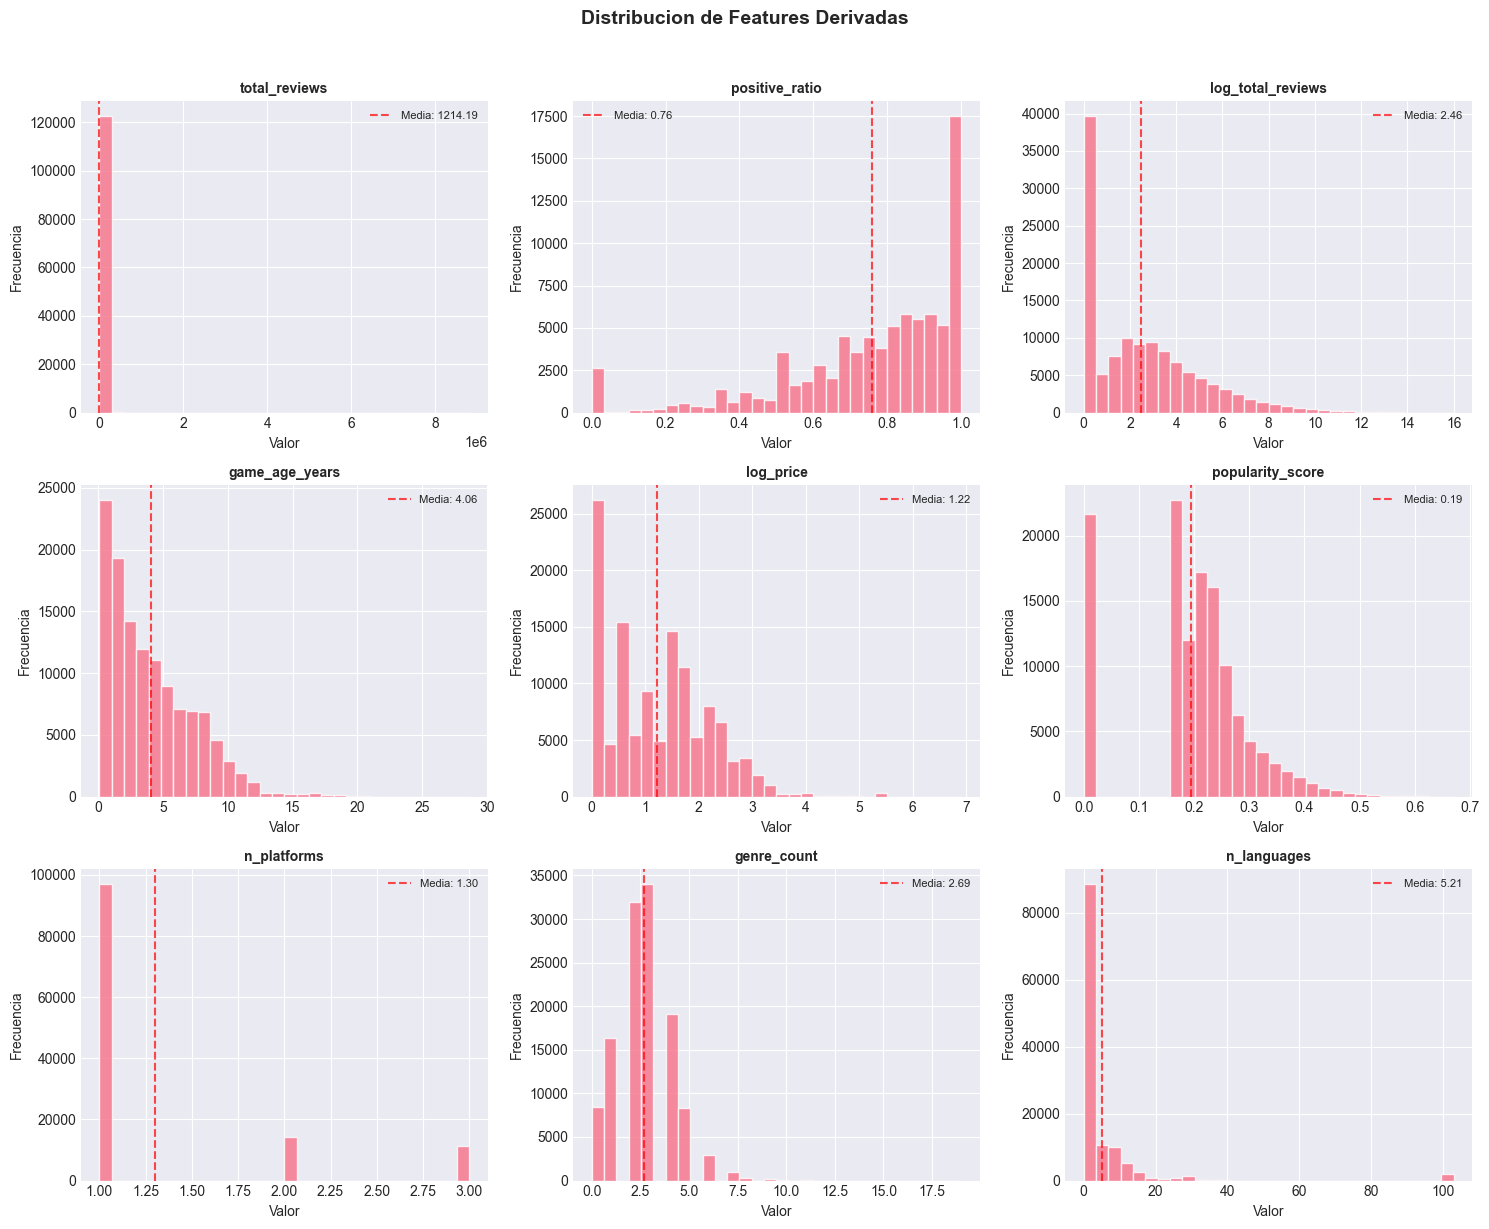

Figura guardada: C:\Users\Christian Ruiz\Maestria_DS\Gestion_Datos\reports\figures\distribucion_features_derivadas.png


In [15]:
# Visualizar importancia relativa de features numericas derivadas
num_derived = ['total_reviews', 'positive_ratio', 'log_total_reviews',
               'game_age_years', 'log_price', 'popularity_score',
               'n_platforms', 'genre_count', 'n_languages']

existing_num_derived = [c for c in num_derived if c in df.columns]

if existing_num_derived:
    fig, axes = plt.subplots(3, 3, figsize=(15, 12))
    axes = axes.flatten()
    
    for i, col in enumerate(existing_num_derived[:9]):
        data = df[col].dropna()
        axes[i].hist(data, bins=30, edgecolor='white', alpha=0.8)
        axes[i].set_title(f'{col}', fontweight='bold', fontsize=10)
        axes[i].set_xlabel('Valor')
        axes[i].set_ylabel('Frecuencia')
        axes[i].axvline(data.mean(), color='red', linestyle='--', alpha=0.7, label=f'Media: {data.mean():.2f}')
        axes[i].legend(fontsize=8)
    
    # Ocultar subplots vacios
    for j in range(len(existing_num_derived), 9):
        axes[j].set_visible(False)
    
    plt.suptitle('Distribucion de Features Derivadas', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    fig.savefig(FIGURES_DIR / 'distribucion_features_derivadas.png', dpi=150, bbox_inches='tight')
    plt.show()
    print(f'Figura guardada: {FIGURES_DIR / "distribucion_features_derivadas.png"}')

## 7. Guardado del Dataset de Features

In [16]:
today = date.today().isoformat()

# Seleccionar columnas para el dataset de features de ML
# Excluir columnas de texto libre y columnas originales reemplazadas
exclude_cols = [
    'name', 'short_description', 'score_rank', 'supported_languages',
    'genres_str', 'categories_str', 'developers_str', 'publishers_str',
    'tags_top5', 'estimated_owners', 'release_date'
]

# Mantener columnas numericas, booleanas y encoded
df_features = df.drop(columns=[c for c in exclude_cols if c in df.columns])

# Convertir booleanos a int para compatibilidad con scikit-learn
bool_cols_to_convert = df_features.select_dtypes(include='bool').columns.tolist()
for col in bool_cols_to_convert:
    df_features[col] = df_features[col].astype(int)

# Convertir categoricals a string
cat_cols = df_features.select_dtypes(include='category').columns.tolist()
for col in cat_cols:
    df_features[col] = df_features[col].astype(str)

output_path = PROCESSED_DATA_DIR / f'steam_games_features_{today}.csv'
df_features.to_csv(output_path, index=False, encoding='utf-8')

print(f'Dataset de features guardado: {output_path}')
print(f'Shape final: {df_features.shape}')
print(f'Tamano del archivo: {output_path.stat().st_size / 1024**2:.2f} MB')

# Guardar diccionario de features
feature_dict = {
    'n_total_features': df_features.shape[1],
    'n_registros': len(df_features),
    'columnas': list(df_features.columns),
    'dtypes': df_features.dtypes.astype(str).to_dict(),
    'fecha_generacion': today
}

import json
dict_path = PROCESSED_DATA_DIR / f'steam_feature_dictionary_{today}.json'
with open(dict_path, 'w', encoding='utf-8') as f:
    json.dump(feature_dict, f, indent=2, ensure_ascii=False)

print(f'Diccionario de features guardado: {dict_path}')

Dataset de features guardado: C:\Users\Christian Ruiz\Maestria_DS\Gestion_Datos\data\processed\steam_games_features_2026-02-12.csv
Shape final: (122610, 115)
Tamano del archivo: 104.21 MB
Diccionario de features guardado: C:\Users\Christian Ruiz\Maestria_DS\Gestion_Datos\data\processed\steam_feature_dictionary_2026-02-12.json


## 8. Resumen del Feature Engineering

### Variables Derivadas Creadas:

| Feature | Tipo | Descripcion |
|---|---|---|
| `total_reviews` | int | Suma de reviews positivas + negativas |
| `positive_ratio` | float [0,1] | Proporcion de reviews positivas |
| `review_label` | str | Etiqueta tipo Steam (Very Positive, Mixed, etc.) |
| `review_label_encoded` | int [0-7] | Encoding ordinal del review label |
| `log_total_reviews` | float | log1p(total_reviews) - reduce skewness |
| `game_age_years` | float | Anos desde el lanzamiento |
| `era` | str | Era de Steam (5 categorias) |
| `era_encoded` | int [0-5] | Encoding ordinal de era |
| `is_recent` | bool | Lanzado en los ultimos 2 años |
| `is_free` | bool | Juego gratuito (price == 0) |
| `price_tier` | str | Segmento de precio (6 niveles) |
| `log_price` | float | log1p(price) |
| `price_per_hour` | float | Precio dividido por horas jugadas |
| `n_platforms` | int [0-3] | Numero de plataformas soportadas |
| `is_multiplatform` | bool | Soporta mas de una plataforma |
| `platform_combo` | str | Combinacion exacta de plataformas |
| `owners_midpoint` | float | Punto medio del rango de owners |
| `popularity_score` | float [0,1] | Score combinado de popularidad |
| `developer_freq` | float | Frecuencia normalizada del developer |
| `publisher_freq` | float | Frecuencia normalizada del publisher |
| `*_std` | float | Columnas numericas estandarizadas |
| `*_robust` | float | Columnas numericas escaladas con RobustScaler |
| `tags_top5_tfidf_*` | float | Features TF-IDF de los top tags |
| `genres_str_tfidf_*` | float | Features TF-IDF de generos |

### Siguiente Paso:
Cargar `data/processed/steam_games_features_YYYY-MM-DD.csv` en el notebook `03_visualizaciones_insights_steam.ipynb`.